This document describes the creation of a graph, where airports are nodes and routes between the airports are the links. Furthermore various statistics are done on the graph, such as community detection, shortest paths, centrality measures and sentiment analysis done on the different airports combined with the analysis of the graph. The purpose of the sentiment analysis is to identify popular and unpopular airports and try to relate as to why they are popular or unpopular.

# Importing data

Initially, the data is loaded in. The *routes.csv* file contains the cleaned data set on all routes between the airports that are stored in the *airports.csv* file.

In [1]:
import pandas as pd

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

# Creating a directed multigraph

In [5]:
import networkx as nx

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [ ]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

Due to some routes having an invalid source/destination, due to the airport not existing in the airport dataset, these routes are removed. The remaining routes and airports are added to the graph.

In [8]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes]

airport_routes_digraph.add_edges_from(edges);

# Plotting the graph

In [ ]:
import matplotlib.pyplot as plt

Methods are the defined for getting longitude and latitudes for different airports. This is used to determine the location of the nodes when plotting the graph.

In [ ]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [ ]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    

When plotting the graph axes are removed.

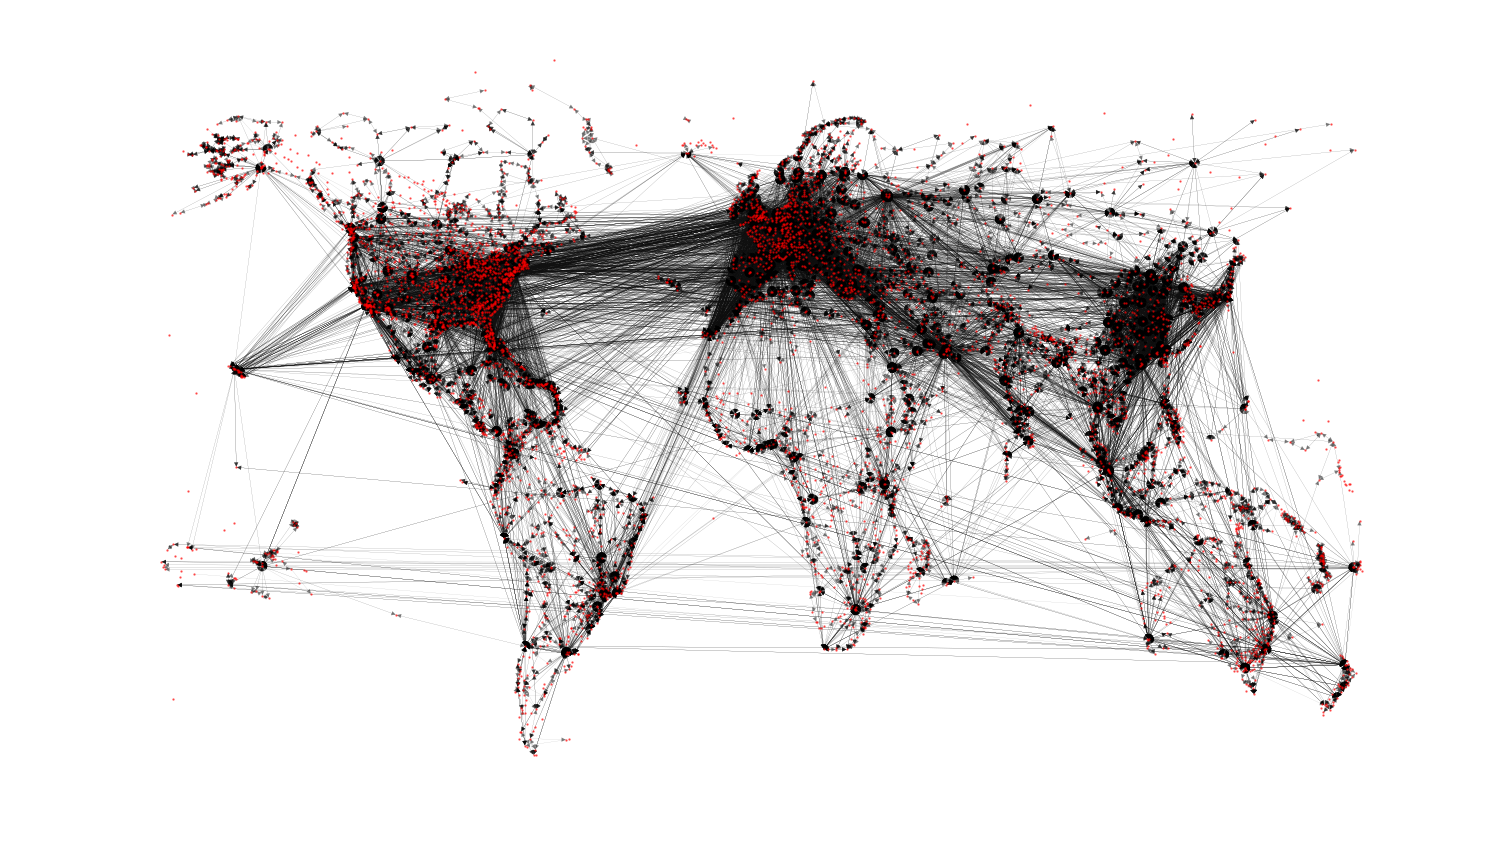

In [12]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph.png", transparent=True, bbox_inches='tight')

In [51]:
"The graph has " + str(len(airport_routes_digraph.nodes)) + " nodes."

'The graph has 5653 nodes.'

In [52]:
"The graph has " + str(len(airport_routes_digraph.edges)) + " edges."

'The graph has 66067 edges.'

As can be noted, the graph is rather large. The large amount of edges compared to nodes is expected considering we're dealing with airports. Airports tend to be very well connected to each other, and even smaller airports tend to offer a fair amount of flights to different destinations.

In the following, the degree distribution of the graph is plotted regularly and as a loglog plot.

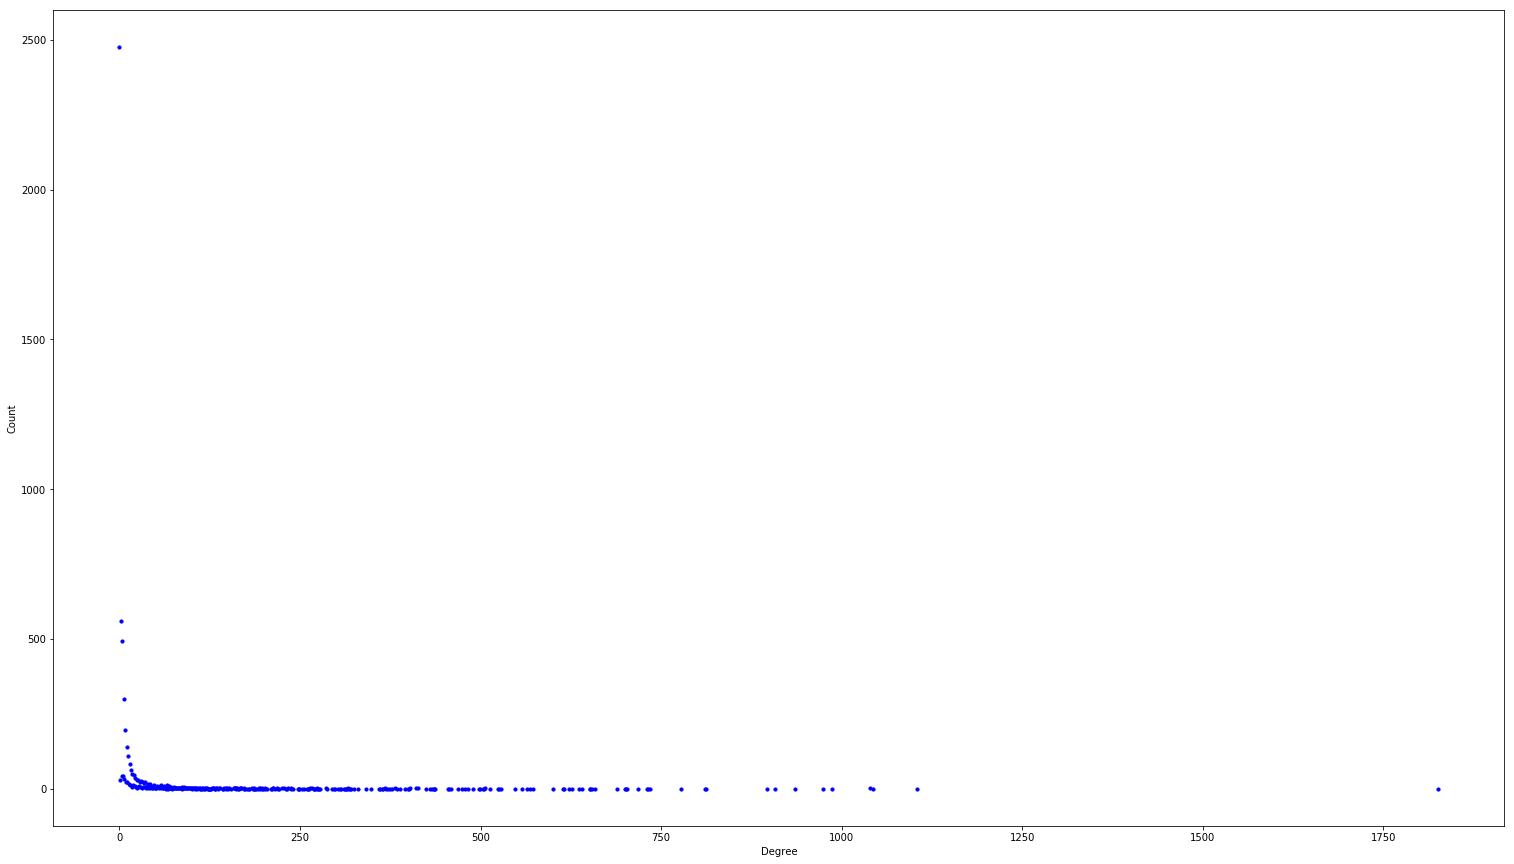

In [15]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/regularplot.png', bbox_inches='tight')

In [ ]:
plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/powerlawplot.png', bbox_inches='tight')

## Analysing the loglog plot

The above loglog plot could be interpreted as the network consisting of two sub graphs that are scale-free. This is however not the case, as the graph does not contain any major sub graphs that are disconnected from the main graph. This will be further considered later, when considering longest shortest paths.

If the loglog plot is further considered, it can be noted that 30 airports have only 1 route. Remembering that the graph is directed, this does not make much sense, since it would be expected that an airport has atleast two routes. 

**Consdering airports with only route**

The airports with only one route are the following:

In [80]:
print([a for (a,i) in list(airport_routes_digraph.degree()) if i is 1])


['MLY', 'KZI', 'STZ', 'LUR', 'XMS', 'SLQ', 'AGN', 'TUA', 'CMP', 'PIP', 'KUK', 'JQE', 'MSW', 'KYK', 'DLZ', 'PTJ', 'PTH', 'PTU', 'LJA', 'VDA', 'SIC', 'IUE', 'BVS', 'TTA', 'UII', 'FMI', 'SXX', 'ELV', 'KPV', 'TLJ', 'IGG']


MLY is the Manley Hot Springs Airport which is located in Alaska, and has a single grass strip. Since the routes dataset focuses mostly on commerical traffic, the smaller airports tend to not be included. These smaller airport tend to be used for general aviation and scheduled commercial flights. 

There are however some airports, such as KPV, which is a larger national airport in the US, which in reality have a fair amount of flights, but in the dataset doesn't have any. This example shows that the data isn't totally complete, but this doesn't prevent a meaningful analysis.


Furthermore, the reason for the airportrs only having one route could be due to inconsistencies between the airport and routes dataset. Remembering that some routes were removed due to invalid source or desintation airports, it could be the case that some of the airports for the routes were incorrectly added to the routes dataset. Thus some routes have been removed leading to some airports only having one route. Generally, this has to be kept in mind when considering the degree for all airports.

**Further considerations**

Further, it can be considered how around 500 airports have degree 2 and 3. These are very small airports with very little traffic. As expected in a scale free network, which is what the network clearly is, there are much fewer airports with high degree. When considering air traffic, this makes a lot of sense. 

The way airlines like to design their routes is by focusing around having a central hub. This is an airport that offers a large amount of different routes to many smaller airports from the hub. Thus if a traveller were to go a long distance, they would firt take a smaller flight to a hub, from where they would be transported to their desired location. You therefore end up with a lot of airports with fewer routes (generally routes where the destination is a hub) and fewer airports with a large amount of routes.

# Community Detection

Initialy, the best community partition is found. It will then be possible to compare various custom community paritions with the best partition. These custom partitions will be partioning the communities by country and by continent.

**Best Community Partition**

In [17]:
import community
from collections import Counter

In [18]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

In [81]:
"Modularity of the best partition: " + str(community.modularity(community_partition,airport_routes_digraph.to_undirected()))

'Modularity of the best partition: 0.262247551601'

In [85]:
countercoms = Counter(community_partition.values())
print("Top ten biggest communities out of " + str(len(set(community_partition.values()))) + " communities:")
print(sorted(countercoms.values()))[-10:]

Top ten biggest communities out of 2495 communities:
[28, 130, 143, 163, 190, 288, 383, 420, 594, 733]


As we can see (notice the plot below), the best community partition is a rather random one, which consists of a few communities containing many airports, but many communities with few airports. 
It would make sense that many of the larger airports that are interconnected would share the same community, e.g. many of larger airports in Europe and North America, as it can be seen from the plots that Europe and North America are especially well connected. One could consider that less connected areas in Afria and South America could create their own community, but it seems to be the case that some of the airports of less connected areas join the larger communities by just having a very few amount of connections to these highly connected areas, e.g. Europe. This makes sense given the previous comments made on the general hub structure that airlines tend to create for their routes.

The modularity for the best partition is 0.26, which is postive, but still sub-optimal. Considering that most airports are likely to be connected to another well connected airport (if it isn't well connected itself) it makes sense that the modularity isn't very high.

**Best partition community plot**

In [21]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

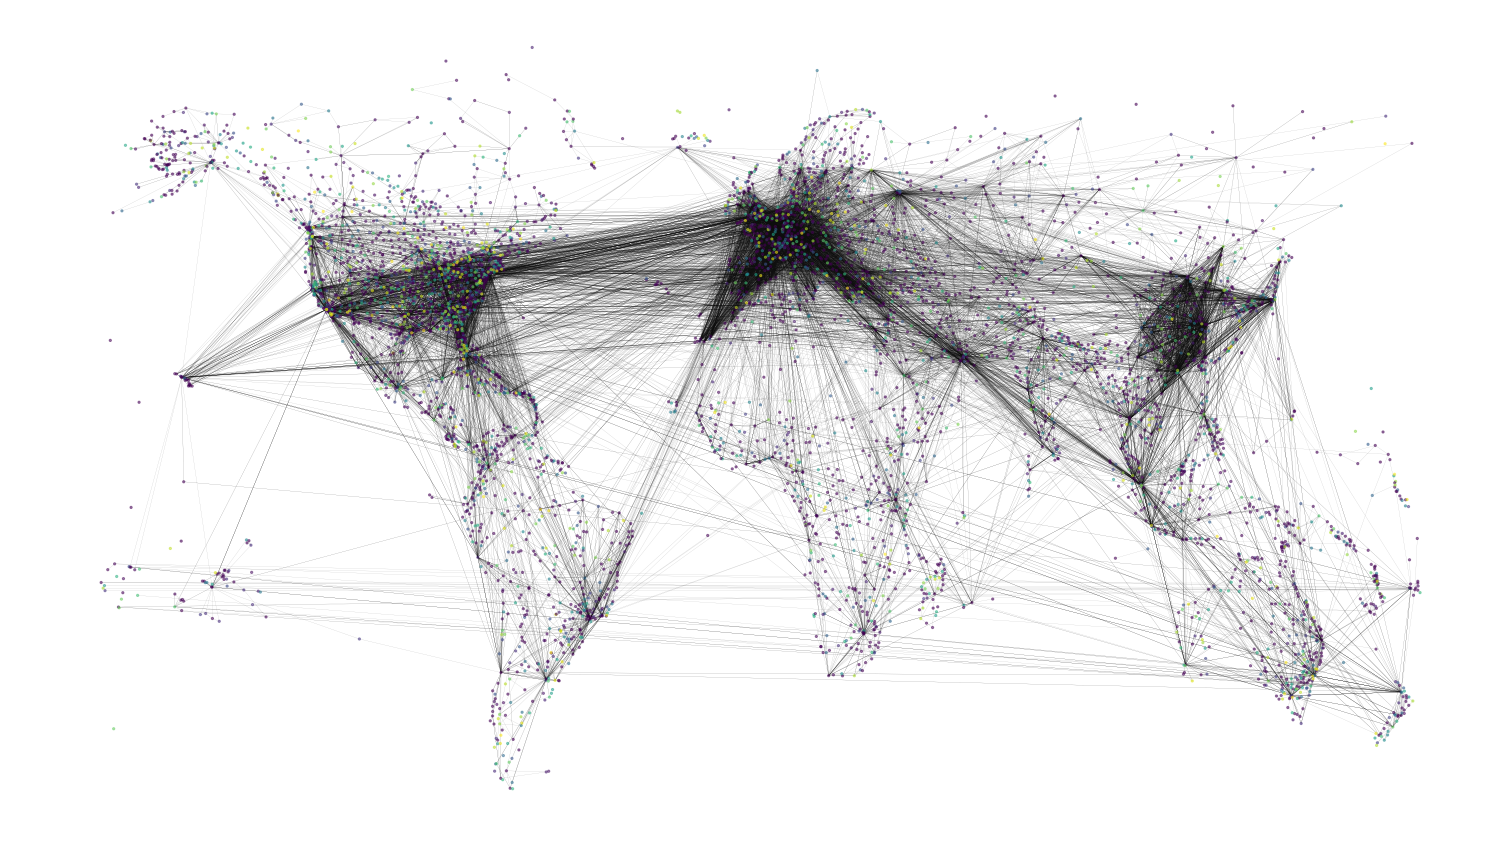

In [22]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=5,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_communities.png", transparent=True, bbox_inches='tight')

## Communities by Continent

Now the a custom community partition is considered, where each continent is its own community. What is expected here is that continents will tend to have a lot of flights internally on the same continent, but will have some hubs that connect the continents together.

**Preparing the data**

In [23]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [24]:
countriescontinents_df.set_index(['Country','Continent']);

In [25]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [26]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [27]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [28]:
def calculateLC(graph,community_df):
    lc = 0
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


**Calculating modularity**

In [29]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) + Mc(airport_routes_digraph,oce_df) + Mc(airport_routes_digraph,afr_df) + Mc(airport_routes_digraph,asia_df) + Mc(airport_routes_digraph,na_df) + Mc(airport_routes_digraph,sa_df)

In [86]:
"The modularity for the continent partition: " + str(modularity)

'The modularity for the continent partition: 0.236926150726'

**Commenting on modularity**

When dividing the different continents into different communities, a modularity that is almost as high as the best community partition modularity is achieved. Even though the modularity is not very high, i.e. sub-optimal, it is positive that using continents as communities is close to the best possible community partition. 

It would make sense that partitioning by continent would create a sub-optimal community partition. Continents tend to have a fair amount of flights going within the continent, due to the physical size of the continents. This is also visible in the various plots. There are however still many intercontinental flights, which heavily lowers the modularity which is also why it is hard to find a good community partition. The different airports around the world are simply very well interconnected.

**Community by continent plot**

In [31]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

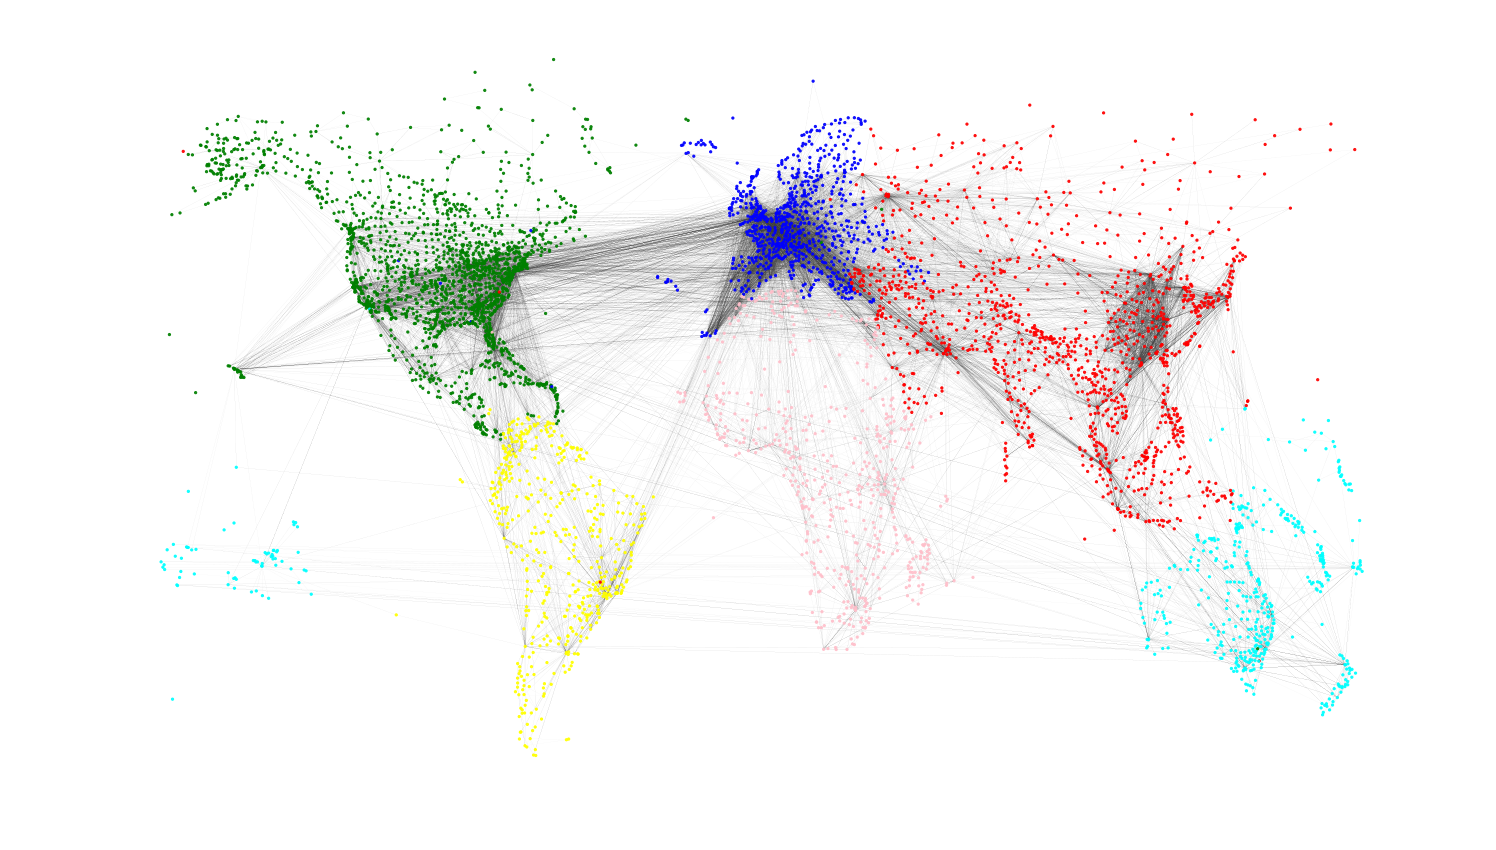

In [32]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_continent_communities.png", transparent=True, bbox_inches='tight')

# Communities by Countries

**Calculating modularity**

In [33]:
countries = list(airports_df.groupby('Country').groups)

In [34]:
country_dfs = []

In [35]:
for country in countries:
    country_dfs.append((country,list(airports_df.loc[airports_df['Country'] == country].groupby('IATA').groups)))

In [36]:
country_by_modularity =  [(c[0],Mc(airport_routes_digraph,c[1])) for c in country_dfs]
country_com_modularity = sum([Mc(airport_routes_digraph,c[1]) for c in country_dfs])

In [88]:
"Modularity for the country community partition: " + str(country_com_modularity)

'Modularity for the country community partition: 0.130662811994'

**Finding the countries that contribute most to the modularity**

In [38]:
countries_sort_by_mod = sorted(country_by_modularity,key = lambda (k,v):(v,k),reverse=True)
top_10_country_mod = countries_sort_by_mod[:10]
bot_10_country_mod = countries_sort_by_mod[-10:]

print("Top 10:")
print(top_10_country_mod)
print(" ")
print("Bottom 10:")
print(bot_10_country_mod)

Top 10:
[('United States', 0.04116275901736116), ('China', 0.01994187718528161), ('Canada', 0.006190685213495391), ('Brazil', 0.005305220458019889), ('Russia', 0.005123586662024914), ('Australia', 0.0033375210014076617), ('Japan', 0.0026336900419271347), ('India', 0.002595849667761515), ('Mexico', 0.002421783946599664), ('France', 0.002361239347934672)]
 
Bottom 10:
[('Belarus', 0.0), ('Barbados', 0.0), ('Bahrain', 0.0), ('Aruba', 0.0), ('Armenia', 0.0), ('Antigua and Barbuda', 0.0), ('Antarctica', 0.0), ('Anguilla', 0.0), ('American Samoa', 0.0), ('Albania', 0.0)]


**Commenting on modularity**

The modularity when creating communities based on countries is very low. This makes sense, since most countries are not very big and do not have a lot of domestic flights. Therefore many of outgoing flights from those countries are international. The bigger countries should be more ideal as a community, since their vast area would imply more domestic flights, but there aren't that many very large countries and  they too have large international airports connecting the country to other contintents. This is also exactly what can be noted by looking at the top 10 and bottom 10 countries by their contribution to the modularity of the whole community. The bottom 10 are smaller countries, and in many cases small islands, which further proves the above statement.

**Country partition community plot**

In [39]:
countrylabels = []
for node in airport_routes_digraph.nodes():
    countrylabels.append(countries.index(list(airports_df.loc[airports_df['IATA'] == node]['Country'])[0]))

In [40]:
colors = list(map(plt.cm.get_cmap('hsv', len(set(countries))+1),countrylabels))

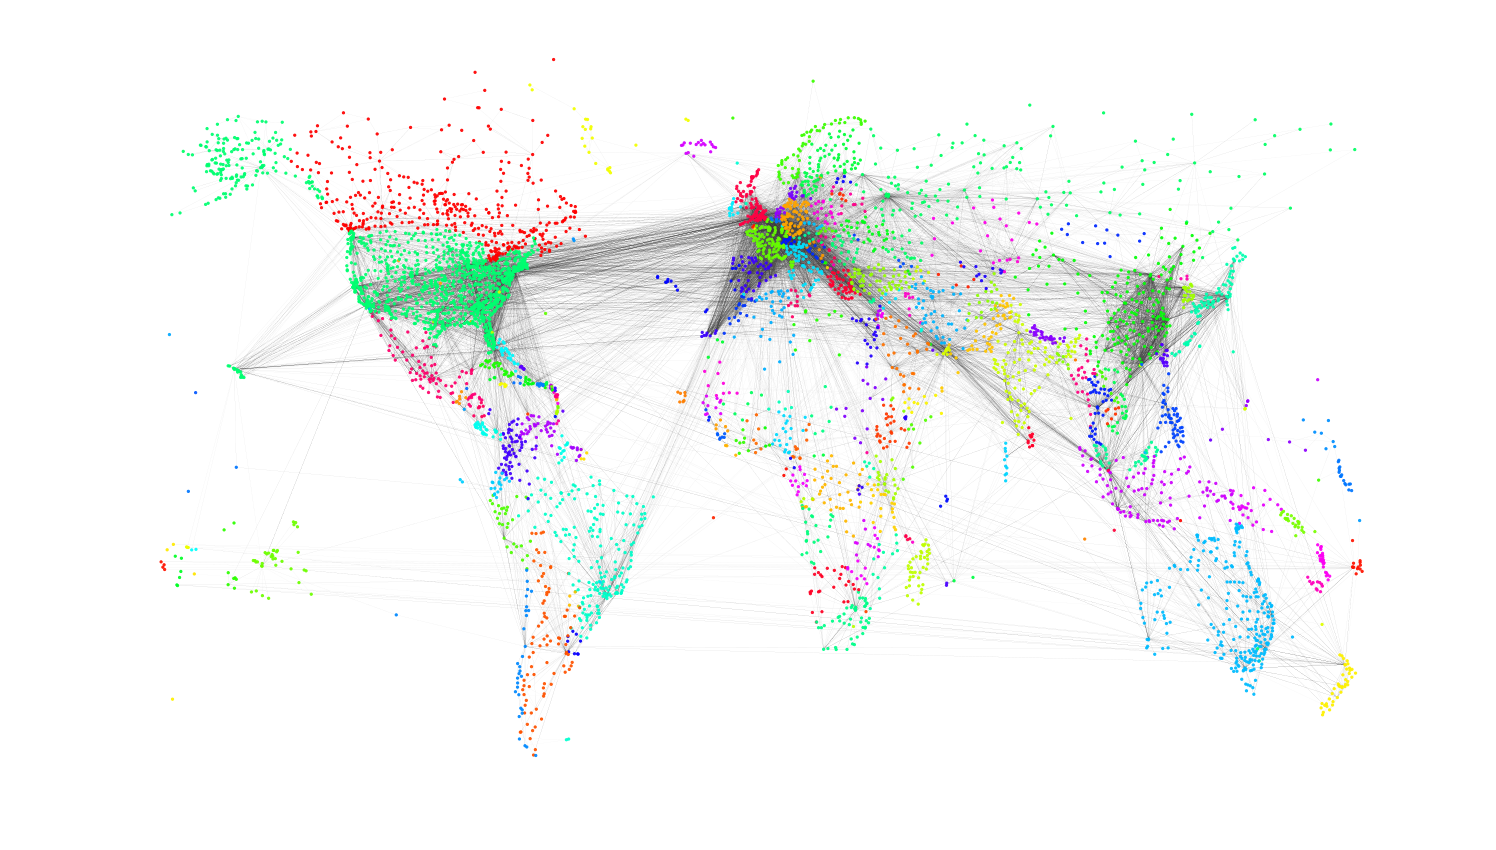

In [41]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = colors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_country_communities.png", transparent=True, bbox_inches='tight')

# Further Community Analysis

It was chosen also to analyze, whether hub airports tend to connect communities together. Here we're keeping the community partition using continents in mind, since it makes more sense to analyze that partition, than the best partition which at a quick glance is nonsensical.

**Plotting the location of the top 10 hubs**

In [42]:
#The following hubs are found based on degree.
hubs = ['Hartsfield Jackson Atlanta International Airport',"Chicago O'Hare International Airport",
        'Beijing Capital International Airport','Charles de Gaulle International Airport',
        'London Heathrow Airport','Los Angeles International Airport',
        'Frankfurt am Main International Airport','Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport','John F Kennedy International Airport']

In [43]:
nodesizes = []
nodeColors = []

#Hubs are colored xxx and a given a larger size than the remaining airports.
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    if (list(airports_df.loc[airports_df['IATA'] == node]['Name'])[0] in hubs):
            nodeColors.append('red')
            nodesizes.append(100)
    else:        
        nodesizes.append(2)
        if continent == 'Asia':
            nodeColors.append('purple')
        elif continent == 'Europe':
            nodeColors.append('blue')
        elif continent == 'Oceania':
            nodeColors.append('cyan')
        elif continent == 'Africa':
            nodeColors.append('pink')
        elif continent == 'North America':
            nodeColors.append('green')
        elif continent == 'South America':
            nodeColors.append('yellow')    
        else:
            nodeColors.append('brown')

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.9,node_color=nodeColors,node_size=nodesizes,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_with_high_degree_hubs.png", transparent=True, bbox_inches='tight')

**Analysing the plot**

Considering the plot above, the red plots are the hubs that were defined. What could be considered is whether or not the hubs tend to be links between communities. This has to be the case. Due to the fact that a given node is a hub, must also indicate that this node will be connecting communities together, since the hubs in general are major international airports that have flights between many different continents. It could be the case that the hub only connects with other nodes in the same community, but this would be most likely be a regional airport and the major hubs are definetely not regional airports.

## Cleaning up, making the graph weakly connected

In order to find the shortest paths, the graph had to be weakly connected, i.e. removing subraphs which is completly unconnected with the rest of the graph, keeping the largest connected subgraph.

In [45]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from(edges);

# Average shortest path 

In [46]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected)

print "Edges in graph: " + str(airport_undirected.number_of_edges())
print "Nodes in graph: " +  str(airport_undirected.number_of_nodes())
big_subgraph = max(subgraphs,key=lambda x: x.number_of_edges())

print
print "Edges in subgraph: " + str(big_subgraph.number_of_edges())
print "Nodes in subgraph: " +  str(big_subgraph.number_of_nodes())

Edges in graph: 66068
Nodes in graph: 3186

Edges in subgraph: 33913
Nodes in subgraph: 3154


In [47]:

print "The average shortest path through out our network is: " + str(nx.average_shortest_path_length(big_subgraph))

The average shortest path through out our network is: 3.96089581421


With the average shortest path of 4, it indicates how few flights are required to travel to the other side of the planet. It also shows that most trips requires a few extra flights to reach an international airport, when flying between smaller airports.

# Longest Shortest Path

In [48]:
shortest_path_lengths = sorted([(k, max(zip(v.values(), v.keys()))) for k,v in tqdm(nx.shortest_path_length(big_subgraph))],key=lambda x: x[1][0],reverse=True)[:10]

NameError: name 'tqdm' is not defined

### The shortest paths

In [ ]:
paths = []
for item in shortest_path_lengths:
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

In [ ]:
print paths[0]
for p in paths[0]:
    print airports_by_iata_df.get_group(p).iloc[0]['Name']

In [ ]:
print len(paths[0])

A trip that requires one to fly from the outskirts of Australia to the outskirts of Canada, a flight between quite alot of smaller airports. Especially in Canada, where the trip requires one to fly in between lots of small airports, with very short trips in between, results in a trip with alot of connecting flights.

In [ ]:
edgeys = []
for i in range(0,len(paths[0])-1):
    edgeys.append((paths[0][i],paths[0][i+1]))

In [ ]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

positions = {}

for node in airport_undirected.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    
    
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=edgeys, width = 2, alpha = 1, edge_color='r')
plt.axis('off')
fig.show()

Here the longest trip, in terms of number of airports, can be seen. 12 connecting flights

In [ ]:
fig.savefig("output/longest_shortest_path.png",transparent=True, bbox_inches='tight')

In [ ]:
d = dict(nx.degree(big_subgraph))

## Node size in terms of node degree

In [ ]:
fig_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_degree.show()

With many flight routes across the Atlantic, it is not very surprising that lots of the airports in Europe and the Americas have rather high degrees. With so many airports in Europe, it is hard to detect specific airports with high degree. On the west coast of the US, it is possible to detect LAX (Los Angeles International Airport), a very large airport which have many international flights to Europe and national flights around the US.

In [ ]:
fig_degree.savefig("output/graph_degree_size.png",transparent=True, bbox_inches='tight')

## Node size in terms of betweenness centrality

In [ ]:
bc = nx.betweenness_centrality(big_subgraph)
fig_betweeness = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_betweeness.show()

Here we see the graph, plotting the nodes' sizes in terms of there betweenness centrality. Here LAX is visible again, more clearly, and it also shows lots of the european airports have high betweeness centrality. Interestingly, one airport in Alaska have a rather high betweenness centrality, which one would think is because this airport connects the rest of the smaller Alaskan airports to the rest of the world. There are also a few airports over in the east (China, Japan and Australia) which stand alone with a rather high betweenness centrality. This indicates that these airports connects there respective areas to the rest of the world.

In [ ]:
fig_betweeness.savefig("output/graph_betweeness_centrality.png",transparent=True, bbox_inches='tight')

## Node size in terms of eigenvector centrality

In [ ]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
fig_eigen = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 3000 for v in ec.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_eigen.show()

The eigenvector centralities lightens up the world, making the nodes brighten up. This indicates that the world's airports are very connected, easily giving lots of the different airports high scores in terms of eigenvector centrality.

In [ ]:
fig_eigen.savefig("output/graph_eigenvector_centrality.png",transparent=True, bbox_inches='tight')

## Airports with the most connections (highest degree)

In [ ]:
top_airports_degree = sorted(d.iteritems(),key = lambda (k,v):(v,k),reverse=True)[:10]
for ai,de in top_airports_degree:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], de)

## Airports with the highest betweeness centrality

In [ ]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], be)

Besides the more famous and busy international airports, which also was present in the airports with highest degree, one can also see the outlier of Ted Stevens Anchorage International Airport. This airport, as mentioned before is placed in Alaska, and has the task of connecting many of the Alaskan airports to the rest of the world, resulting in this airport having a large betweenness centrality.

## Airports with the highest eigenvector centralities

In [ ]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], ee)

# Analysis of graph i terms of sentiment

In [ ]:
Airport_Name_IATA = {}
for _,row in airports_df.iterrows():
    Airport_Name_IATA[row['Name']] = row['IATA']

In [ ]:
import unicodecsv as csv
import codecs
'''
def unicode_csv_reader(utf8_data, dialect=csv.excel, **kwargs):
    csv_reader = csv.reader(utf8_data,delimiter='\t', dialect=dialect, **kwargs)
    for row in csv_reader:
        yield [unicode(cell, 'utf-8') for cell in row]
'''
sentiment_dict= {}
with open("output/airport_sentiment.csv") as csv_file:
    csv_reader = csv.reader(csv_file,delimiter='\t',encoding='utf-8')
    linecount = 0
    for row in csv_reader:         
        
        if linecount != 0 and row[0] in Airport_Name_IATA:
            iata = Airport_Name_IATA[row[0]]
            if iata in big_subgraph.nodes():
                sentiment_dict[iata] = float(row[1])
        linecount += 1
        

In [ ]:
print sentiment_dict

In [ ]:
sentiment_mean = mean(sentiment_dict.values())
sentiment_min = min(sentiment_dict.values())
sentiment_max = max(sentiment_dict.values())
print sentiment_mean
print sentiment_min
print sentiment_max

In [ ]:
color_map = []
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

for n in sentiment_dict.values():
    if n <= sentiment_mean:
        color_map.append(convert_to_hex([1,(sentiment_mean-sentiment_min)-(sentiment_mean-n),(sentiment_mean-sentiment_min)-(sentiment_mean-n)]))
    else:
        color_map.append(convert_to_hex([(sentiment_max-sentiment_mean)-(n-sentiment_mean),1,(sentiment_max-sentiment_mean)-(n-sentiment_mean)]))

## Most positive airports

In [ ]:
fig_positive = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 100**(v - sentiment_min) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive.show()

Surprisingly it seems that the airports with the highest sentiment is placed in the Middle East. This could because of the large economies which have financed these airports. More over, airports in Alaska also seem to have a high sentiment.

In [ ]:
fig_positive.savefig("output/graph_positive_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Most negative airports

In [ ]:
fig_negative = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 150**(sentiment_max - v) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative.show()

Here we see that alot of the airports in nothern and southern Europe have very low sentiments and joining them are a few airports off the coast of Africa.

In [ ]:
fig_negative.savefig("output/graph_negative_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Negative airports with high degree

In [ ]:
fig_negative_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (3**(sentiment_max - v))*d[k] for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative_degree.show()

In [ ]:
fig_negative_degree.savefig("output/graph_negative_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Positive airports with high degree

In [ ]:
fig_positive_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (3**(v - sentiment_min))*d[k] for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive_degree.show()

In [ ]:
fig_positive_degree.savefig("output/graph_positive_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Absolute sentiment

In [ ]:
fig_absolute = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 3000**abs(v - sentiment_mean) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute.show()

Here we see the negative and positive sentimented airports joined in one plot.

In [ ]:
fig_absolute.savefig("output/graph_absolute_sentiment.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. degree

In [ ]:
max_degree = max(d.values())

In [ ]:
fig_absolute_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ d[k]**(abs(v - sentiment_mean)*1.5)*4 for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_degree.show()

In [ ]:
fig_absolute_degree.savefig("output/graph_absolute_sentiment_degree.png",transparent=True, bbox_inches='tight')

In [ ]:
fig_absolute_mindegree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (max_degree - d[k])**(abs(v - sentiment_mean)*1.5) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_mindegree.show()

In [ ]:
fig_absolute_mindegree.savefig("output/graph_absolute_sentiment_min_degree.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. lattitude and longitude

In [ ]:
airport_iata_latitude = {}
airport_iata_longitude = {}
for _,row in airports_df.iterrows():
    airport_iata_latitude[row['IATA']] = row['Latitude']
    airport_iata_longitude[row['IATA']] = row['Longitude']

### Near the equator

In [ ]:
fig_absolute_latitude_equator = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((90-abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_equator.show()

In [ ]:
fig_absolute_latitude_equator.savefig("output/graph_absolute_latitude_equator.png",transparent=True, bbox_inches='tight')

### Near the poles

In [ ]:
fig_absolute_latitude_poles = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2.5)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_poles.show()

In [ ]:
fig_absolute_latitude_poles.savefig("output/graph_absolute_latitude_poles.png",transparent=True, bbox_inches='tight')

### Middle longitude

In [ ]:
fig_absolute_longitude_zero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((180-abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_zero.show()

In [ ]:
fig_absolute_longitude_zero.savefig("output/graph_absolute_longitude_zero.png",transparent=True, bbox_inches='tight')

### Away from middle longitude (?? what)

In [ ]:
fig_absolute_longitude_nonzero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_nonzero.show()

In [ ]:
fig_absolute_longitude_nonzero.savefig("output/fig_absolute_longitude_nonzero.png",transparent=True, bbox_inches='tight')

# Tweets sentiment

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
from PIL import Image
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [ ]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [ ]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

In [ ]:
airports

## TF-IDF analysis of Twitter

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.

In [ ]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopworld, punctuation, and blacklisted words, such as keywords used by twitter.

In [ ]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [ ]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

In [ ]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each of the words occure in takes some time, we have cheated a little and saved the result. To optimize the calculations, we have transformed each of the documents into sets.

In [ ]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [ ]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the IDF can now be done using the following function.

In [ ]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

In [ ]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in tqdm(list(airports['Name']))
}

Calculate the TF_IDF

In [ ]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [ ]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

In [ ]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

The most used words in all of the documents:

In [ ]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [ ]:
freqency_total = FreqDist(all_tokens)

## Word clouds

In [ ]:
def drawWordCloud(text: str, title: str, mask: str = None):
    if mask:
        mask = np.array(Image.open(os.path.join('masks', mask)))
        
    wordcloud = WordCloud(
        collocations=False,
        mask=mask,
#         background_color='white',
        contour_width=3, 
        contour_color='steelblue'
        ).generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
#     ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    imageio.imwrite(f'output/{title}.png', np.array(wordcloud))
    plt.show()

In [ ]:
combined_all_tokens = ' '.join(all_tokens)

In [ ]:
drawWordCloud(combined_all_tokens, 'All tokens', 'Airplane_silhouette.png')

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [ ]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')

We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.

In [ ]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

In [ ]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

In [ ]:
tweets_list = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

In [ ]:
tweets_tokenized = { 
    airport: [tokenize(tweet) for tweet in ts]
    for airport, ts in tweets_list.items()
}

In [ ]:
sentiment = {
    airport: [calculate_sentiment(tweet, h_avg) for tweet in ts]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [ ]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

Plot the distribution of the sentiment in all of the tweets.

In [ ]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

In [ ]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

In [ ]:
mean = np.mean(sentiment_all)
std = np.std(sentiment_all)
print('Sentiment mean and standard deviation of all the tweets. Mean: {0:f} sigma: {1:f}'
      .format(mean, std))

Analysis tweets based on sentiment

In [ ]:
negative_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean - 2*std]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in negative_tweets.values() for t in ts]), 
      'Negative tweets', 'Airplane_silhouette.png')

When looking at the words most used in the negative tweets, we see that they are a lot of account names are used, such official airport accounts.
The word *queue* can also be found in here, which is to be expected.

Looking at words in the positive tweets

In [ ]:
positive_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean + 2*std]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in positive_tweets.values() for t in ts]), 
      'Positive tweets', 'Airplane_silhouette.png')

For the positive tweets, we see words such as *office*, which would point to many people are enjoying working from the airport.
Words like *bar*, *resturant*, and *nightclub* are also found, poniting to that most people enjoy being at these places.

## The least and most liked airports in the world

In [ ]:
sentiment_avg = {
    airport: np.mean(values)
    for airport, values in sentiment.items()
}

In [ ]:
sorted_sentiment = sorted(sentiment_avg.items(), key=lambda x: x[1])

In [ ]:
def showAirportScore(airport: str):
    print(f'{airport}'.ljust(50), f'{sentiment_avg[airport]}')

First we can find the mean and standard deviation of the sentiment of the airports.

In [ ]:
print('Mean and standard deviation sentiment of the airports: mean: {0:f}, sigma: {1:f}'
     .format(np.mean(list(sentiment_avg.values())), np.std(list(sentiment_avg.values()))))

Now we can find the top five least and most liked airports in the world.

In [ ]:
print('The least liked airports in the world')
for airport, _ in sorted_sentiment[:5]:
    showAirportScore(airport)

In [ ]:
print('The most liked airports in the world')
for airport, _ in sorted_sentiment[::-1][:5]:
    showAirportScore(airport)

In [ ]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [ ]:
for airport in busiest_airports:
    showAirportScore(airport)

In the output above, it can be seen that most of the busiest airports in the world is close to the average of all of the airports in the world, however all of them is slightly below.
London Heathrow Airport and Tokyo Haneda International Airport are quite low on the list, while Dubai International Airport is most more liked than all of the other busy airports.

## Exporting results

In [ ]:
import csv

In [ ]:
with open('./output/airport_sentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(('Airport', 'Sentiment'))
    for row in sorted_sentiment:
        writer.writerow(row)

In [ ]:
with open('./output/sentiment_all.txt', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_all):
        if value < 10 and value != 0:
            f.write(str(value) + '\n')